# Machine Learning in Python - Group Project 1

**Due Friday, March 10th by 16.00 pm.**

*Matthew Backhouse, Monica Stephanie, Ross Campbell, Royce Yan*

**Matt's Notes**:
- Possibly remove outlier and boxplot graphs? Unless we really are using what they are saying <-- Agree Matt, i'll remove it
- In 2.2, the function iqr to remove outliers is not used yet (or at least I don't see it being used yet) <-- Agree too, i'll remove it
- In 2.2, you mention you are removing irrelvant columns, where is this happening and what columns are you removing? <-- I think my wording is messed up lol, instead of removing, it is "choosing only relevant columns"

**Notes**:
- scikit-learn==1.2.1
- add `warnings.filterwarnings('ignore')` in lib/python3.9/site-packages/sklearn/preprocessing/_label.py to suppress warnings by `MultiLabelBinarizer()`

## General Setup

In [1]:
# Add any additional libraries or submodules below

# Data libraries
import numpy as np
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn modules that are necessary
from sklearn.preprocessing import MultiLabelBinarizer, PowerTransformer, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.inspection import permutation_importance
from sklearn import set_config
from scipy.stats import randint

# Other modules that are necessary
from difflib import get_close_matches
from bs4 import BeautifulSoup
from numpy.linalg import norm
import re
import requests
import warnings
import spacy
import forestci as fci

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80
sns.set_theme(style='darkgrid')
%matplotlib inline
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

# Others
warnings.filterwarnings('ignore')
set_config(transform_output='pandas')

In [2]:
# Load the spaCy model
# !python -m spacy download en_core_web_lg
nlp = spacy.load('en_core_web_lg')

In [3]:
# Load data
data = pd.read_csv('the_office.csv')
data_guest_star = pd.read_csv('guest_duration_office.csv')

After making sure that all the necessary libraries or submodules are uploaded here, please follow the given skeleton to create your project report. 
- Your completed assignment must follow this structure 
- You should not add or remove any of these sections, if you feel it is necessary you may add extra subsections within each (such as *2.1. Encoding*). 

**Do not forget to remove the instructions for each section in the final document.**

## 1. Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a client).* 

- If you use any additional data sources, you should introduce them here and discuss why they were included.

- Briefly outline the approaches being used and the conclusions that you are able to draw.

The aim of this project to advise NBC Universal on how to create the best reunion episode for the world's famous sitcom The Office (US). In order to do this we will explore and outline factors that made an episode popular. Namely using the episode's IMDB rating as a basis and exploring different factors affecting it, such as which director, number of words spoken and main characters. We will then build an understandable and validated model for the IMBD rating as the outcome of interest using features from 'the_office.csv' and 'guest_duration_office.csv'. 

From the 'guest_duration.csv' file we added the following parameters to our dataframe:
1. Viewership - The live viewership when the epiosode aired. We included this because we found it has a strong correlation to IMDB rating.
2. Guest_stars - A list of any guest stars in the episode. We included this to explore any guest stars that have a strong impact on the IMBD rating. We can then add a reccomendation to NBC for any beloved guest stars to include in the reunion episode.
3. Duration - The length of the episode. This was added as we can easily find an optimal epsiode duration to recommend to NBC.

The breakdown of the report is as follows:
1. [**Exploratory data analysis and feature engineering:**](#2) The objective of this section is to explore the data which means finding correlations and relationships, identifying key factors affecting IMDB rating. We will also clean the data by removing duplicates, fixing spelling errors amongst other minor changes. * A sentence or two about feature engineering
2. [**Model Fitting and Tuning:**](#3) TBA
3. [**Dicussion and conclusion**](#4): TBC when we start it

## <a id=2> 2. Exploratory Data Analysis and Feature Engineering </a>

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling.* 

- Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. 
- Think carefully about whether each plot needs to be included in your final draft - your report should include figures but they should be as focused and impactful as possible.

*Additionally, this section should also implement and describe any preprocessing / feature engineering of the data.*

- Specifically, this should be any code that you use to generate new columns in the data frame `d`. All of this processing is explicitly meant to occur before we split the data in to training and testing subsets. 
- Processing that will be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

**All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.**

The following section reviews and analyzes the data to ensure it is preprocessed appropriately for the model in section 3. Two data sets are viewed, analyzed, preprocessed, and then combined to create the final data set that will be viewed. The first data set is **the_office.csv** (which is in the pandas dataframe *data*) originally given in the folder provided for this project. The other data set is **guest_duration_office.csv** (which is in the pandas dataframe *data_guest_star*). This dataset contains much of the same information, such as episode title and season, however, it also contains guest stars that appear in each episode, the viewership and duration of each episode which will be included as features in our dataset. Both data sets are described in further detail in subsection 2.1. The datasets are cleaned separately based on our observations in section 2.1 and then merged based on episode title. The correlations between features is investigated to be used conducting feature extraction to help determine which features we may not use as they do not display much variance in our dataset, this will be done with PCA as well. Finally, the numeric columns are standardized and the categorical columns are encoded. This section will ensure that the data is appropriately analyzed, cleaned and preprocessed so that it is ready for our model

The section is broken down into the following subsections:

- [**2.1. Data Exploration**](#21): Provide an overview of data sets *data* and *data_guest_star*. The data is described by giving statistics, unique values for each column and data structure so that readers can better understand the data and to identify if any data cleaning.
- [**2.2. Data Cleaning**](#22): Clean the data based on data exploration.
- [**2.3. Data Correlation**](#23): Understand the correlation among all the features.
- [**2.4. Feature Extraction**](#24): Extract highly correlated features and add new features based on given features.
- [**2.5. Feature Scaling & Selection**](#25): Standardize numeric values and encode categorical values.

### <a id=21>  2.1. Data Exploration </a>
This subsection aims to provide a comprehensive view of *data* and *data_guest_star* using `describe_data` function. The objective of this section is to identify whether any data cleansing needs to be performed on the data, e.g., fixing typo, null values imputation, etc, before feeding it into the model.\\

The data structure, sample, descriptive statistics, unique values, histograms and box plots of the dataset are also provided. This is all to help ideintify any data cleansing that might be necessary. First the dataset *data* (which is the data from **the_office.csv**) is viewed, and then the dataset *data_guest_star* (which is the data from **guest_duration_office**) is viewed.


In [4]:
def describe_data(data):
    """
    Provides the data structure, sample, descriptive statistics, and unique values of the data.
    This function aims to give insights about the content of the dataset and inform users whether any data
    cleansing process needs to be done.
    
    Parameters
    ----------
    data: Raw data (pandas.DataFrame)
    
    Raises
    ------
    AssertionError raised if data is empty
    """
    
    data_length = len(data)
    
    # Raising errors if data is empty
    if data_length == 0:
        raise AssertionError(f'Data is empty.')
    
    print('----- Data Structure -----')
    display(data.info())
    
    print('----- Descriptive Statistics -----')
    display(data.describe())
    
    data_num = data.select_dtypes(include=['float64', 'int64'])
    if len(data_num.columns) > 0:
        print('----- Histogram -----')
        fig, ax = plt.subplots(1, len(data_num.columns), figsize=(15,3))
        fig.tight_layout(w_pad=2)
        for i, col in enumerate(data_num.columns):
            sns.histplot(data_num[col], ax=ax[i])
        plt.show()
    
    print('----- Unique Values -----')
    for col in data.columns:
        unique_vals = sorted(data[col].dropna().unique())
        length_unique_vals = len(unique_vals)
        
        if length_unique_vals <= data_length/3:
            print(f'{col} has {length_unique_vals} unique values: {unique_vals}\n')
        else:
            print(f'{col} has {length_unique_vals} unique values.\nFirst 3: {unique_vals[:3]}\nLast 3: {unique_vals[-3:]}\n')
            
    print('----- Sample: Row 20-24 -----')
    display(data.loc[20:24])

----- Data Structure -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   season        186 non-null    int64  
 1   episode       186 non-null    int64  
 2   episode_name  186 non-null    object 
 3   director      186 non-null    object 
 4   writer        186 non-null    object 
 5   imdb_rating   186 non-null    float64
 6   total_votes   186 non-null    int64  
 7   air_date      186 non-null    object 
 8   n_lines       186 non-null    int64  
 9   n_directions  186 non-null    int64  
 10  n_words       186 non-null    int64  
 11  n_speak_char  186 non-null    int64  
 12  main_chars    186 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 19.0+ KB


None

----- Descriptive Statistics -----


,season,episode,imdb_rating,total_votes,n_lines,n_directions,n_words,n_speak_char
count,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000
mean,5.462366,12.478495,8.250538,2129.543011,296.397849,50.150538,3053.510753,20.693548
std,2.398464,7.233710,0.535168,790.787586,81.998568,23.941797,799.271717,5.092407
min,1.000000,1.000000,6.700000,1393.000000,131.000000,11.000000,1098.000000,12.000000
25%,3.000000,6.000000,7.900000,1628.500000,255.250000,34.000000,2670.250000,17.000000
50%,6.000000,12.000000,8.200000,1954.000000,281.000000,46.000000,2872.500000,20.000000
75%,7.750000,18.000000,8.600000,2385.000000,314.500000,60.000000,3141.000000,23.000000
max,9.000000,28.000000,9.700000,7934.000000,625.000000,166.000000,6076.000000,54.000000


----- Histogram -----


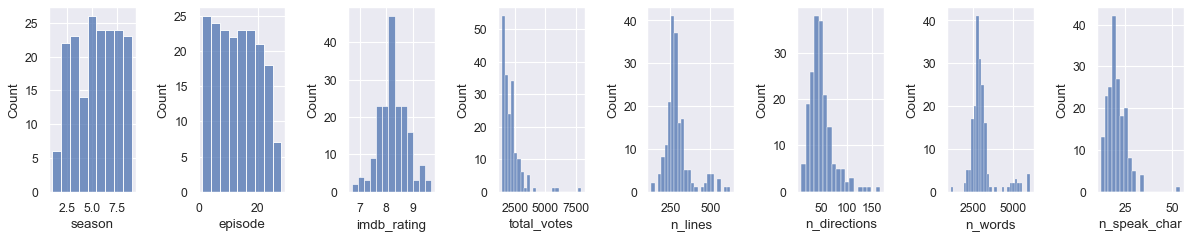

----- Unique Values -----
season has 9 unique values: [1, 2, 3, 4, 5, 6, 7, 8, 9]

episode has 28 unique values: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

episode_name has 186 unique values.
First 3: ['A Benihana Christmas (Parts 1&2)', 'A.A.R.M', 'After Hours']
Last 3: ["Women's Appreciation", 'Work Bus', 's*x Ed']

director has 61 unique values: ['Alex Hardcastle', 'Amy Heckerling', 'Asaad Kelada', 'B.J. Novak', 'Brent Forrester', 'Brian Baumgartner', 'Bryan Cranston', 'Bryan Gordon', 'Charles McDougal', 'Charles McDougall', 'Charlie Grandy', 'Claire Scanlon', 'Claire Scanlong', 'Craig Zisk', 'Daniel Chun', 'Danny Leiner', 'David Rogers', 'Dean Holland', 'Dennie Gordon', 'Ed Helms', 'Eric Appel', 'Gene Stupnitsky;Lee Eisenberg', 'Greg Daneils', 'Greg Daniels', 'Harold Ramis', 'J.J. Abrams', 'Jason Reitman', 'Jeffrey Blitz', 'Jennifer Celotta', 'Jesse Peretz', 'John Krasinski', 'John Scott', 'Jon Favreau', 'Joss Whedon', '

,season,episode,episode_name,director,writer,imdb_rating,total_votes,air_date,n_lines,n_directions,n_words,n_speak_char,main_chars
20,2,15,Boys & Girls,Dennie Gordon,B.J. Novak,8.2,2323,2006-02-02,281,20,3063,21,Angela;Darryl;Dwight;Jim;Kelly;Kevin;Meredith;...
21,2,16,Valentine's Day,Greg Daniels,Michael Schur,8.3,2345,2006-02-09,198,50,2482,18,Angela;Dwight;Jim;Kelly;Kevin;Meredith;Michael...
22,2,17,Dwight's Speech,Charles McDougal,Paul Lieberstein,8.4,2463,2006-03-02,206,27,2612,16,Angela;Creed;Dwight;Jim;Kelly;Kevin;Michael;Os...
23,2,18,Take Your Daughter to Work Day,Victor Nelli Jr.,Mindy Kaling,8.3,2415,2006-03-16,264,52,2740,25,Angela;Creed;Darryl;Dwight;Jim;Kelly;Kevin;Mer...
24,2,19,Michael's Birthday,Ken Wittingham,Gene Stupnitsky;Lee Eisenberg,8.1,2337,2006-03-30,248,47,2331,19,Angela;Dwight;Jim;Kelly;Kevin;Meredith;Michael...


In [5]:
describe_data(data)

----- Data Structure -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    188 non-null    int64  
 1   Season        188 non-null    int64  
 2   EpisodeTitle  188 non-null    object 
 3   About         188 non-null    object 
 4   Ratings       188 non-null    float64
 5   Votes         188 non-null    int64  
 6   Viewership    188 non-null    float64
 7   Duration      188 non-null    int64  
 8   Date          188 non-null    object 
 9   GuestStars    29 non-null     object 
 10  Director      188 non-null    object 
 11  Writers       188 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 17.8+ KB


None

----- Descriptive Statistics -----


,Unnamed: 0,Season,Ratings,Votes,Viewership,Duration
count,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000
mean,93.500000,5.468085,8.237234,2838.228723,7.246330,27.053191
std,54.415071,2.386245,0.589930,1063.165290,2.066012,6.937254
min,0.000000,1.000000,6.600000,1832.000000,3.250000,19.000000
25%,46.750000,3.000000,7.800000,2187.750000,5.990000,22.000000
50%,93.500000,6.000000,8.200000,2614.000000,7.535000,23.000000
75%,140.250000,7.250000,8.600000,3144.250000,8.425000,30.000000
max,187.000000,9.000000,9.800000,10515.000000,22.910000,60.000000


----- Histogram -----


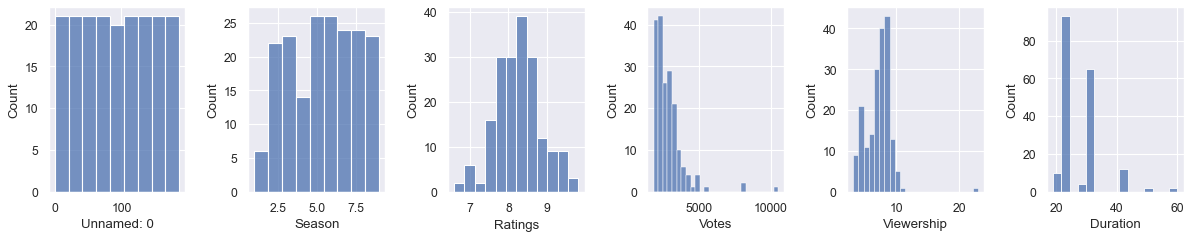

----- Unique Values -----
Unnamed: 0 has 188 unique values.
First 3: [0, 1, 2]
Last 3: [185, 186, 187]

Season has 9 unique values: [1, 2, 3, 4, 5, 6, 7, 8, 9]

EpisodeTitle has 188 unique values.
First 3: ['A Benihana Christmas', 'A.A.R.M.', 'After Hours']
Last 3: ['Whistleblower', "Women's Appreciation", 'Work Bus']

About has 188 unique values.
First 3: ['A banker representing a potential buyer comes to the Scranton branch to interview the H.R. department before the sale goes through.', 'A confession at an H.R. business ethics seminar leads to a dispute between Michael and Holly over whether Meredith should be fired. Dwight tries to prove to Jim how long he can go without taking a personal break.', 'A fire in the kitchen relegates the staff to the parking lot as help is on its way.']
Last 3: ["While on lecture tour to other Dunder Mifflin branches, Michael and Pam discover that Jim's ex-girlfriend Karen is pregnant. At the office, Andy falls for a prospective client, and Jim and Dwi

,Unnamed: 0,Season,EpisodeTitle,About,Ratings,Votes,Viewership,Duration,Date,GuestStars,Director,Writers
20,20,2,Boys and Girls,Jan comes into the Scranton Branch to give all...,8.2,3091,5.42,22,2 February 2006,NaN,See full summary,B. J. Novak
21,21,2,Valentine's Day,When Michael visits Dunder Mifflin corporate h...,8.3,3104,8.95,22,9 February 2006,Conan O'Brien,Greg Daniels,Michael Schur
22,22,2,Dwight's Speech,Michael coaches pompous Dwight on the finer ar...,8.5,3283,8.40,22,2 March 2006,NaN,Charles McDougall,Paul Lieberstein
23,23,2,Take Your Daughter to Work Day,A routine office day is changed when children ...,8.3,3212,8.80,21,16 March 2006,NaN,See full summary,Mindy Kaling
24,24,2,Michael's Birthday,"In celebration of his birthday, Michael makes ...",8.1,3094,7.80,22,30 March 2006,NaN,Ken Whittingham,Gene Stupnitsky | Lee Eisenberg


In [6]:
describe_data(data_guest_star)

From the above information, it can be concluded that:
1. **data**
    > - **director** column has typos, e.g.: "Claire Scanlon" and "Claire Scanlong" and can be more than 1 person.
    > - **air_date** column datatype is string instead of datetime.
    > - **writer** can be more than 1 person. The column uses ";" as separator.
    > - **main_chars** are more than 1 person. The column uses ";" as separator.
    > - **total_votes** has many outliers, as do columns n_directions, n_lines,n_words and n_speak_char, however not as many as total votes.
    > - **imdb_rating** has an approximately normaal distribution, while other numerical columns are all left skewed distributions.
<br><br>
2. **data_guest_star**
    > - **Unnamed:0** column indicates the row number and can be dropped.
    > - **GuestStars** column has null values and can be more than 1 person.
    > - **EpisodeTitle** column has slightly different values compared to **episode_name** in **data**. For example, for episode 2, episode 10, **EpisodeTitle** is "Boys and Girls" instead of "Boys & Girls" (in **data**).
    > - has more rows than **data** because episode "The Delivery" is separated into 2 parts.
    > - There are outliers in Votes, Viewership and Duration.
    > - **Ratings** is approximately normally distributed while Votes, Viewership and Duration are all left skewed distributions.

### <a id=22>  2.2. Data Cleaning </a>

Based on the data descriptions above, we have identifed issues with our data that need to be fixed, or areas of our data that shoud be altered to clean the data. A function is created to address the alterations that will occur in our data, this function is `get_correct_name` whose function will be explained in this section. Therefore, in this subsection the following tasks are performed on the data:
1. **data**
    > - Fixing typo in **director** column by using `get_correct_name` function.
    > - Parse **director**, **writer**, and **main_chars** as list instead of string.
<br><br>
2. **data_guest_star**
    > - Modify the content of **EpisodeTitle** to follow **episode_name** by using `get_correct_name` function, then take the average of "The Delivery" episode.
    > - Impute null values and parse **GuestStar** as list instead of string.
    > - Choose only relevant columns.

The following function `get_correct_name` takes in two parameters, *list_incorrect_words* and *list_corrected_words* and searches for the closest match in a list of correct words to replace the incorrect word in the list *list_incorrect_words*. This is necessary because some of the directors and writers names are spelt slightly differently in different entries. The episode title of the dataset *data* and *data_guest_star* are also different. In order for the two data sets to be matched, they should be matched by episode title, but these titles first need to be written in the same form. This function is used to correct all three of these complications with our data.

In [7]:
def get_correct_name(list_incorrect_words, list_correct_words):
    """
    Search for the closest match in list_correct_words to replace the incorrect word.
    This function utilizes regex and get_close_matches from difflib library.
    Reference: https://docs.python.org/3/library/difflib.html
    
    Parameters
    ----------
    list_incorrect_words: a sequence of incorrect words that needs to be replaced (list).
    list_correct_words: a sequence of correct words that will be used as the reference (list).
    
    Raises
    ------
    AssertionError if either list_incorrect_words or list_correct_words is null.
    
    Returns
    -------
    corrected_words: a sequence of corrected words based on list_correct_words (pd.Series). 
    """
    
    # Raising errors if data is empty
    if len(list_incorrect_words) == 0:
        raise AssertionError(f'List of incorrect words is empty.')
    elif len(list_correct_words) == 0:
        raise AssertionError(f'List of correct words is empty.')
    
    list_corrected_words = []
    for word in list_incorrect_words:
        # Use regex to search whether the correct word starts with incorrect word.
        # E.g., incorrect: The Job, correct: The Job (Part 1 & 2)
        r = re.compile(f'^{word}')
        corrected_word = list(filter(r.match, list_correct_words))
        
        if len(corrected_word) != 0:
            list_corrected_words.append(corrected_word[0])
        else:
            # Find the best match using get_close_matches
            list_corrected_words.append(get_close_matches(word, list_correct_words, cutoff=0.6, n=1)[0])
        
    return list_corrected_words

The following code utilizes the above two functions to alter the two data sets. The following adjustments are made to the data in the below code:

1. First, the director names that are spelt incorrectly are adjusted using the `get_correct_name` function.
2. The writer, director and main characters are changed into lists, rather than being strings separated by ";".
3. The imdb ratings care categorized. This is so that later, we can ensure that all ratings are included in our training and testing data set. 
4. The episode name in *data_guest_star* is modified to be the same as the episode name in *data*.
5. To ensure we don't have null values in our Guest Stars column, we use "N/A" to represent the null values instead.
6. 
7. The guest star column is changed to a list rather than a string separated by ";".
8. Change the column names of guest stars and episode name in the dataset *data_guest_stars* to ensure it is of the same format as the column names in the dataset *data*.

In [8]:
# 1. data
# Fixing typo in director column
typo_director = ['Charles McDougal', 'Claire Scanlong', 'Greg Daneils', 'Ken Wittingham', 'Paul Lieerstein']
data_cleaned = data.copy().rename(columns={'director':'director_old'})
data_cleaned.loc[:, 'director'] = get_correct_name(data_cleaned['director_old'].values,
                                                   list(filter(lambda x: x not in typo_director, data['director'])))
data_cleaned = data_cleaned.drop(columns='director_old')

# Parse director, writer, and main_chars as list 
for col in ['director', 'writer', 'main_chars']:
    data_cleaned[col] = data_cleaned[col].str.split(';')

# Categorize imdb_rating
data_cleaned['rating_cat'] = data_cleaned['imdb_rating'].apply(lambda x: '<7' if x < 7 else
                                                                         '7-8' if x < 8 else
                                                                         '8-9' if x < 9 else
                                                                         '>9')

# 2. data_guest_star
# Modify EpisodeTitle to follow episode_name column
data_guest_star_cleaned = data_guest_star.copy().rename(columns={'EpisodeTitle':'EpisodeTitle_old'})
data_guest_star_cleaned['EpisodeTitle'] = get_correct_name(data_guest_star_cleaned['EpisodeTitle_old'].values, data['episode_name'].values)

# Impute null values in GuestStars as 'N/A'
data_guest_star_cleaned['GuestStars'] = data_guest_star_cleaned['GuestStars'].fillna('null')

# Remove irrelevant columns and take the average of "The Episode" column
data_guest_star_cleaned = data_guest_star_cleaned.groupby(['Season', 'EpisodeTitle'], as_index=False).agg({'GuestStars':'min', 'Viewership':'sum', 'Duration':'mean'})

# Parse as list
data_guest_star_cleaned['GuestStars'] = data_guest_star_cleaned['GuestStars'].str.split(',')

# Standardize column name
data_guest_star_cleaned.columns = data_guest_star_cleaned.columns.str.lower()
data_guest_star_cleaned = data_guest_star_cleaned.rename(columns={'gueststars':'guest_stars', 'episodetitle':'episode_name'})

### <a id=23> 2.3. Correlation </a>
Now that the data has been cleaned, in this subsection, The data in the dataset *data* and *data_guest_star* is merged and the correlation among the features is shown. The correlation is shown to determine where we have relationships in our data. This acts as a precursor to the feature extraction that will occur in the next section, which will remove and add features, and some highly correlated features or featues that have little affect on the variance of our dataset will be removed.

The following function `get_correlation` takes in a dataframe *df* and outputes the pairplots and the correlation heatmap. This will be used to see the how our features are correlated. 

In [9]:
def get_correlation(df):
    """
    Depicts pairwise plot and Spearman correlation matrix between numerical variables.
    
    Parameters
    ----------
    df: cleaned data that is going to be analyzed (pd.DataFrame).
    """
    
    # Pairwise plot
    sns.pairplot(df)
    
    # Phik correlation matrix
    plt.figure()
    sns.heatmap(df.corr(method='spearman'), annot=True)

The data sets are merged below. Then we will no longer have two datasets, but finally one dataset that includes all of our features. The feautres that have been taken from the dataset *data_guest_stars* that have been added to our original dataset are guest_stars, viewership, and duration of each episode. The datasets are merged based on the episode title and season

In [10]:
# Merge data based on season and episode_name
df = data_cleaned.merge(data_guest_star_cleaned, how='inner', on=['season', 'episode_name'])
df = df.drop(columns=['season', 'episode'])

The following will show the correlation among all numeric features. The pairplots are given and then the correlation heatmap is provided. Below the figures are some explanations of noticable relations in our data

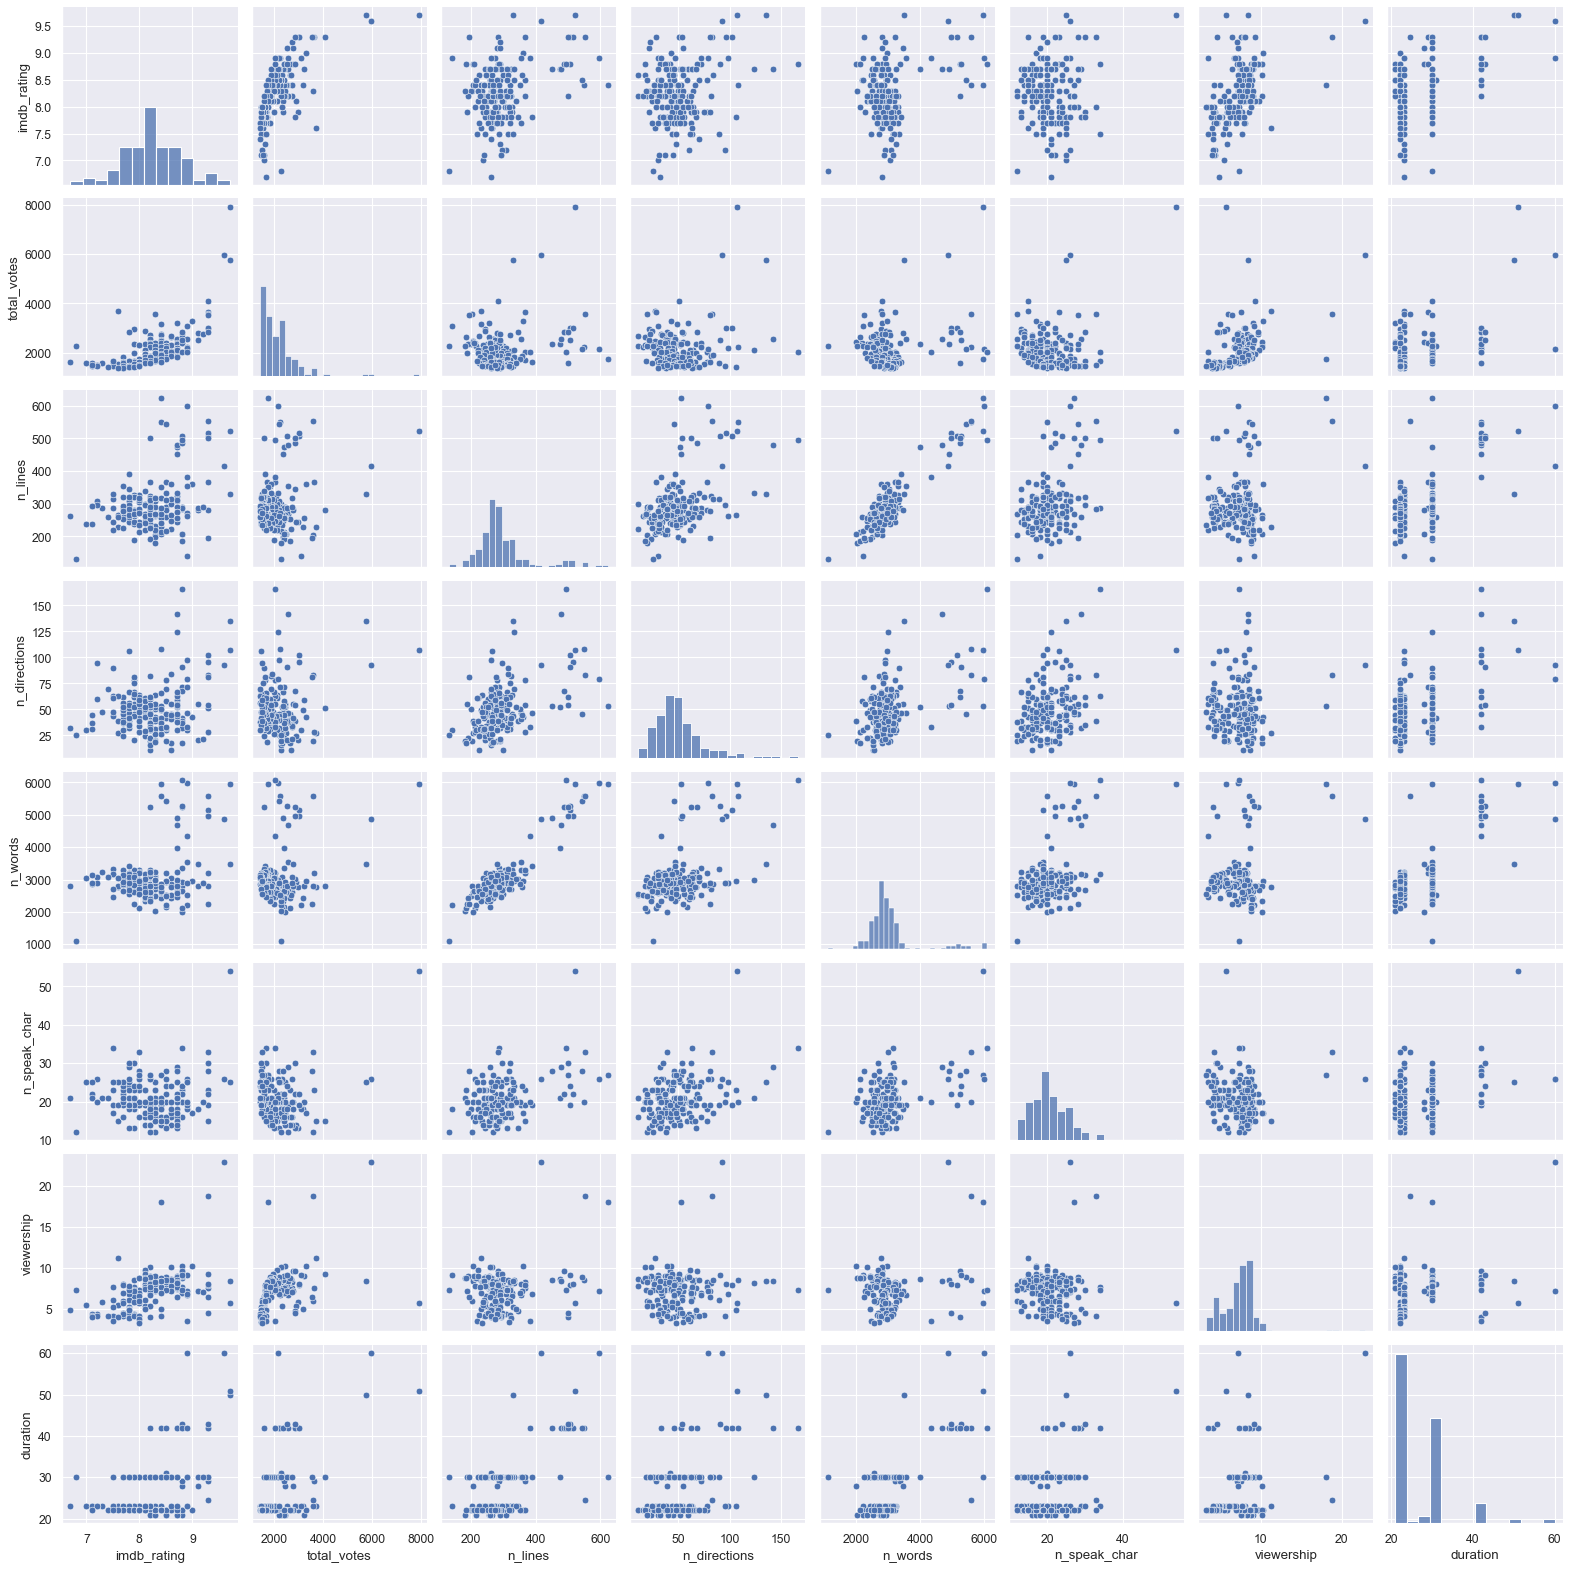

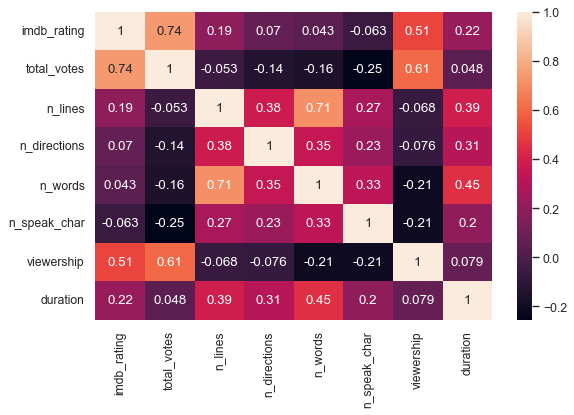

In [11]:
# Show pairwise plot and correlation matrix
get_correlation(df)

Based on the above graphs, there are several key takeaways as follows:
> - There is a very strong relationship between imdb_rating and total_votes. Additionally, there is a strong relationship between imdb_rating and viewership.
> - There is strong relationship between total_votes and viewership.
> - There is a very strong relationship between n_lines and n_words.
> - There is strong relationship between n_words and duration.
> - imdb_rating is a nearly normal distribution.
> - n_lines and n_directions have a weak relationship.
> - imdb_rating and n_lines, n_directions, n_words and n_speak_char have virtually no relationship.

<img src="spearman_interpretation.png" width=600>

The image above provides a view of the spearman correlation coefficient and what the correlation coefficients values mean (values which can be seen in the heatmap). Spearman correlation coefficient is a non-parametric correlation coefficient that measures montonic relationships rather than directly linear relationships. Pearson's correlation also considers that the data is approximiately normally distributed which we are unsure about. It is also easier to consider a montonic relationship in our data rather than a linear relationship as some of our data has outliers and might not represent any type of linear relationship. Spearmans correlation coefficient is therefore the better correlation coefficient to use to measure the correlation among our features. 

### <a id=24> 2.4. Feature Extraction </a>
Based on the aforementioned groundwork, where we integrated several new features from external resources and verified the accuracy of the data used, we will now proceed with feature extraction. This involves using statistical tools to analyse and identify the pertinent features for our target `imda_rating` and referencing additional sources, if need be, to ensure that the variables we use in our model are well-quantified and significantly impact our target.

#### 2.4.1 Basic Extraction
As a preliminary exploration of the data at hand, we have identified through statistical analysis several features as follows:

- The rating of the preceding episode,  as it can serve as an indicator of the overall quality and coherence of the series.
- The number of writers, main characters and guest stars that partake in each episode, since the collaboration among playwrights and involvement of well-known celebrities may herald as a promise.
- For each writer, director and main character in the regarded episode, the average, minimum and maximum rating of the data from the person's works prior to the release of the current title. These features offer a basic revelation of the record of writers, directors and main characters, the major contributors of an episode who arguably influence the image of the work.
- For each writer, director and main character in the regarded episode, the difference between the average of the person's works and the average of all the episodes in *The Office*, based on the data up to the airdate. This feature demonstrates to what extent the concerned person may outperform the average level.

#### 2.4.1 Text Analysis 
Furthermore, to untangle the names of episodes and contributors, we have constructed a benchmark of text using the names of the top-rated episodes and series on IMDB (time-sensitively garnered by the web-scrapping snippet provided before), as well as the keywords that appeared in Google Year In Search from 2004 to 2014. 

In [12]:
# Top highest rating episode name
def get_all_names(urls):
    episode_name, series_name = [],[]
    for url in urls:
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')
        for h in soup.find_all('small', {'class': 'text-primary unbold'}):
            if h:
                episode_name.append(h.find_next_sibling('a').text)
        for h in soup.find_all('span', {'class': 'lister-item-index unbold text-primary'}):
            hh = h.find_next_sibling('a')
            if hh:
                series_name.append(hh.text)
    names = set(series_name + episode_name)
    
    return list(sorted(names))

# Get the list of keywords appeared in Google Year In Search from 2004 to 2014
def read_and_split_by_pattern(filename):
    word_list = []
    with open(filename, 'r') as f:
        for line in f:
            words = re.split(r'\d+\)', line)
            for word in words:
                if word.strip():
                    word_list.append(word.strip())
    return set(word_list)


# Top 50 TV Episode, Rating Count at least 1,000
url = 'https://www.imdb.com/search/title/?title_type=tv_episode&num_votes=1000,&sort=user_rating,desc'
# Top 50 TV Episode, Rating Count at least 10,000
url2= 'https://www.imdb.com/search/title/?title_type=tv_episode&num_votes=10000,&sort=user_rating,desc'
# Top 50 TV Episode
url3= 'https://www.imdb.com/list/ls058613627/'

basis = list(sorted(read_and_split_by_pattern('YearInSearch.txt').union(get_all_names((url, url2, url3)))))

Using the benchmark as a reference, we calculate by a pre-trained NLP model the similarity for the names of episodes and contributors. The similarity metric indicates how closely aligned these names are with trendy names that have street-cred.

#### 2.4.3 Observation and Enlightenment for Data Selection
These features, sequentially, are generated by the following function and stored in DataFrame columns labelled as: *'writer', 'imdb_rating', 'total_votes', 'n_lines', 'n_directions',
'n_words', 'n_speak_char', 'main_chars', 'director', 'rating_cat',
'guest_stars', 'viewership', 'duration', 'imdb_rating_prev',
'writer_mean_rating', 'writer_min_rating', 'writer_max_rating',
'writer_diff_rating', 'director_mean_rating', 'director_min_rating',
'director_max_rating', 'director_diff_rating', 'main_chars_mean_rating',
'main_chars_min_rating', 'main_chars_max_rating',
'main_chars_diff_rating', 'ep_name_flag', 'writer_count',
'writer_pop_rate', 'main_chars_count', 'main_chars_pop_rate',
'guest_stars_count', 'guest_stars_pop_rate', 'year', 'month',
'air_day_of_week'*.

In [13]:
def extract_feature(df, data):
    """
    Generate additional features as follows:
    (1) Number of writers, main characters, and guest stars for each episode
    (2) Rating from previous episode
    (3) length of episode name
    (4) mean, minimum, and maximum rating that has been obtained by writers, director(s), and main characters
    
    Parameters
    ----------
    df: existing dataframe (pd.DataFrame).
    data: existing raw data (pd.DataFrame).
    
    Raises
    ------
    KeyError if any of these columns does not exist:
        - writer
        - director
        - main_chars
        - guest_stars
        - imdb_rating
        - episode_name
        - air_date
    
    Returns
    -------
    df: existing dataframe with additional features (pd.DataFrame).
    """
    
    # Raising errors if any of the required columns does not exist
    for col in ['writer', 'director', 'main_chars', 'guest_stars', 'imdb_rating', 'episode_name', 'air_date']:
        if not col in df.columns:
            raise KeyError(f'Dataframe does not contain {col} column.')  

    # Rating and total_votes from previous episode
    df['imdb_rating_prev'] = df['imdb_rating'].shift(1)

    # Retrieve mean_rating, max_rating, and min_rating from writer, director, and main_chars
    dictionary = {'writer': pd.DataFrame(), 'director': pd.DataFrame(), 'main_chars': pd.DataFrame()}
    for col in dictionary.keys():
        dictionary[col] = (data.set_index(['air_date', 'imdb_rating']) \
                           [col].str.split(';\s*', expand=True) \
                           .stack() \
                           .reset_index() \
                           .drop(columns='level_2') \
                           .pivot_table(index=['air_date'], columns=0))
        dictionary[col] = dictionary[col]['imdb_rating'].reset_index()

        df[col + '_mean_rating'] = df.apply(lambda x: np.nanmean(np.matrix(dictionary[col][dictionary[col]['air_date'] < x['air_date']][x[col]])),
                                            axis=1)
        df[col + '_min_rating'] = df.apply(lambda x: np.nanmin(np.matrix(dictionary[col][dictionary[col]['air_date'] < x['air_date']][x[col]])) \
                                           if len(dictionary[col][dictionary[col]['air_date'] < x['air_date']][x[col]]) != 0 else 0,
                                            axis=1)
        df[col + '_max_rating'] = df.apply(lambda x: np.nanmax(np.matrix(dictionary[col][dictionary[col]['air_date'] < x['air_date']][x[col]])) \
                                           if len(dictionary[col][dictionary[col]['air_date'] < x['air_date']][x[col]]) != 0 else 0,
                                            axis=1)
        df[col + '_diff_rating'] = df.apply(lambda x: np.nanmean(np.matrix(dictionary[col][dictionary[col]['air_date'] < x['air_date']][x[col]])) \
                                            - np.nanmean(data[data['air_date'] < x['air_date']]['imdb_rating']) \
                                           if len(dictionary[col][dictionary[col]['air_date'] < x['air_date']][x[col]]) != 0 else 0,
                                            axis=1).fillna(0)
    
    # Identifier whether the episode_name is similar to the top highest rating episode/_name
    def calculate_similarity(string_A, list_B_docs):
        string_A_doc = nlp(string_A)
        similarities = []
        for doc in list_B_docs:
            if doc.vector_norm:
                similarities.append(string_A_doc.similarity(doc))
        return max(similarities) if similarities else 0.0
    
    list_B_docs = [nlp(phrase) for phrase in basis]
    df['ep_name_score'] = df['episode_name'].apply(lambda x:
                                                   np.nan if x in basis else calculate_similarity(x, list_B_docs))
    
    # Count the number/popularity of writer, main_chars, and guest_stars
    for col in ['writer', 'main_chars', 'guest_stars']:
        df[col + '_count'] = df[col].apply(lambda x: len(x) if x[0] != 'null' else 0)
        df[col + '_pop_rate'] = df[col].apply(lambda x: 
                                              sum([calculate_similarity(string, list_B_docs) for string in x])/len(x))
    
    # Convert dates to a quantifiable type
    df['air_date'] = pd.to_datetime(df['air_date'])
    df['year'] = df['air_date'].dt.year.astype(str)
    df['month'] = df['air_date'].dt.month.astype(str)
    df['air_day_of_week'] = df['air_date'].dt.day_name()
    
    # Drop columns which we have extracted info from
    df = df.drop(columns=['air_date', 'episode_name'])

    return df

df = extract_feature(df, data)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186 entries, 0 to 185
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   writer                  186 non-null    object 
 1   imdb_rating             186 non-null    float64
 2   total_votes             186 non-null    int64  
 3   n_lines                 186 non-null    int64  
 4   n_directions            186 non-null    int64  
 5   n_words                 186 non-null    int64  
 6   n_speak_char            186 non-null    int64  
 7   main_chars              186 non-null    object 
 8   director                186 non-null    object 
 9   rating_cat              186 non-null    object 
 10  guest_stars             186 non-null    object 
 11  viewership              186 non-null    float64
 12  duration                186 non-null    float64
 13  imdb_rating_prev        185 non-null    float64
 14  writer_mean_rating      151 non-null    fl

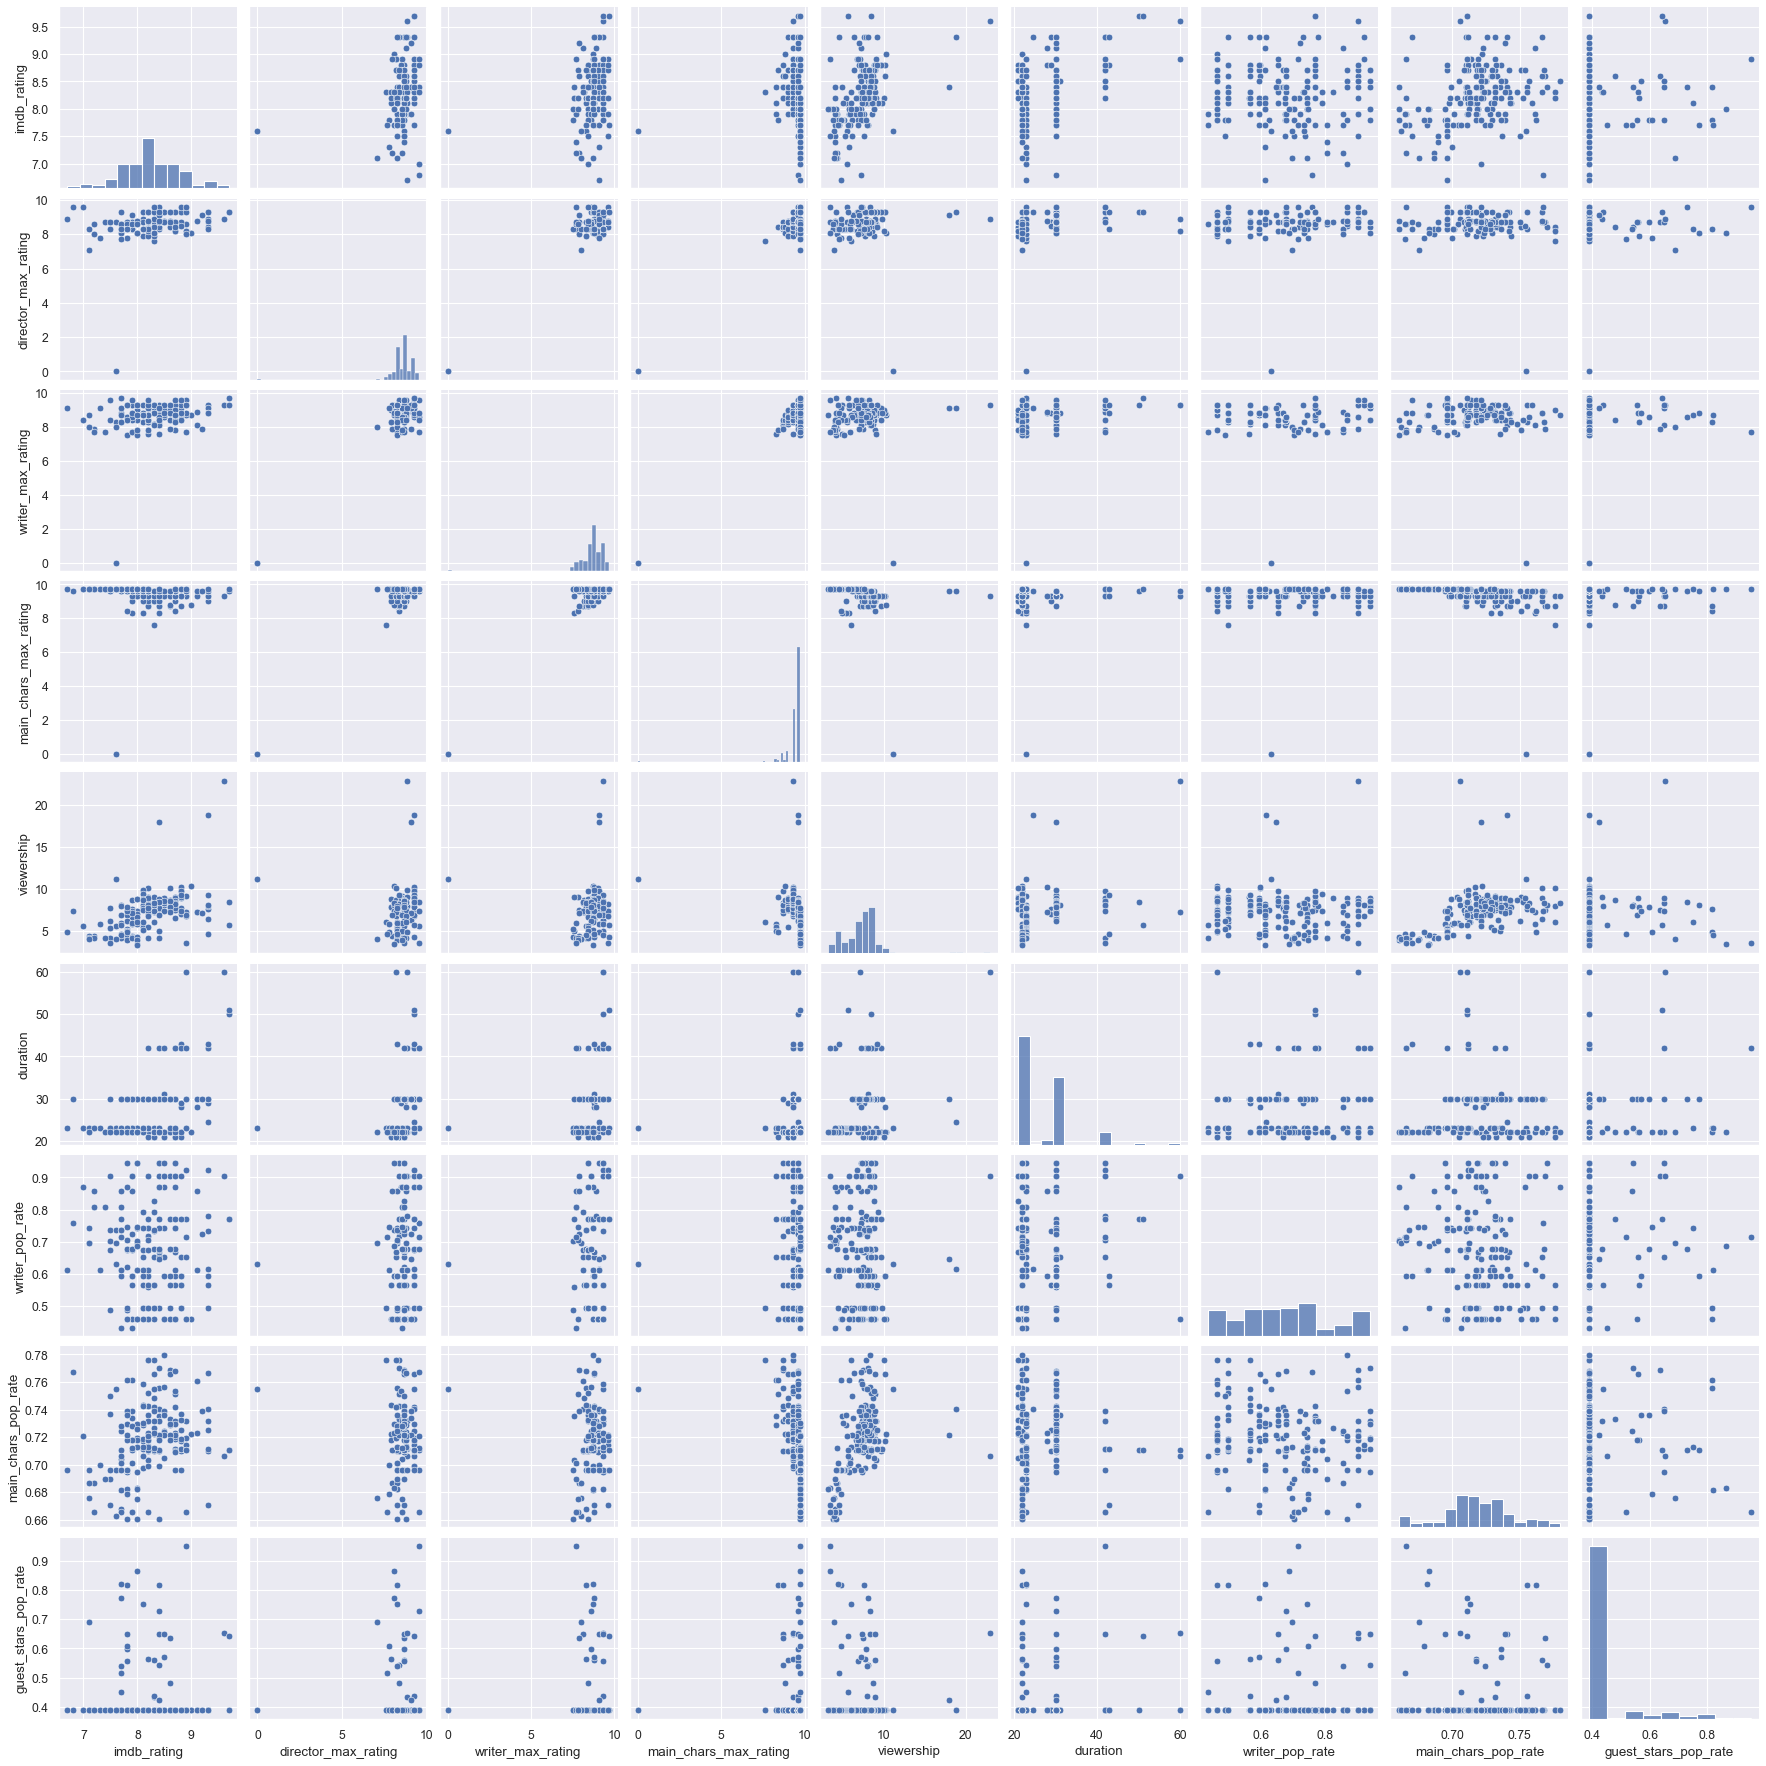

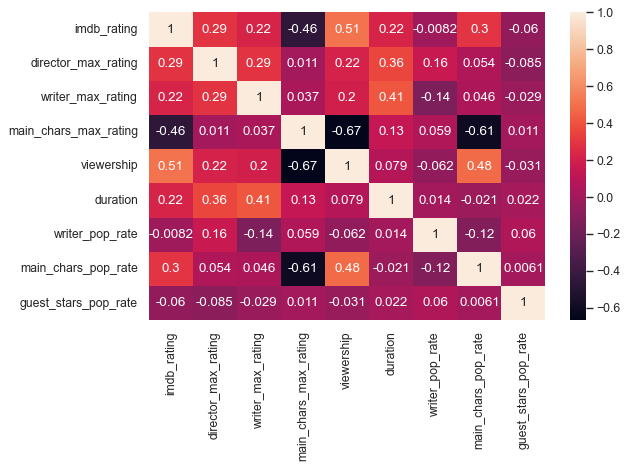

In [14]:
# Show pairwise plot and correlation matrix
get_correlation(df[['imdb_rating', 'director_max_rating', 'writer_max_rating', 'main_chars_max_rating',
                    'viewership', 'duration', 'writer_pop_rate', 'main_chars_pop_rate', 'guest_stars_pop_rate']])

Afterwards, we have sifted out features whose correlation to the target is within the range [-0.1,0.1]. Their significantly feeble correlations enlighten us to consider eliminating these features in the stage of data **selection**.

### <a id=25> 2.5. Feature Scaling & Selection </a>

The following section standardizes the numerical data and one hot encodes the categorical data. The following class and function are defined:
- The class `MultiHotEncoder`
- The class `RenameColumns` is created to create standard column names. Since we used two datasets and have create new columns, it is best that throughout the pipeline all columns have standard names. This will also provide easier access to features throughout the pipeline. This standard, for our purposes, is to have a column name where all letters are lowercase, there is an underscore between words, and that there are no prefixes such as num_cols. 
- A function `preprocess` that standardizes the numerical data and one hot encodes the numerical data.

The following class `RenameColumns` has two functions, fit and transform. The function fit, simple returns an instance of the class itself. The function transform is the key reason why this class is needed. This function will transform the names of the columns to the same standard used in the original dataset. This standard is described above in the first bullet point. To go deeper into why this is necessary, in the pipeline, the outputs are numpy arrays with our features associated with numbers instead of their column names. We then convert this back to a pandas dataframe, however, now the names of the columns are incorrect. This function will then standardize them back to how they were in the original dataset so that all the names are the same across the pipeline. 

In [15]:
class MultiHotEncoder(BaseEstimator, TransformerMixin):
    """
    Wraps `MultiLabelBinarizer` in a form that can work with `ColumnTransformer`.
    Reference: https://stackoverflow.com/questions/59254662/sklearn-columntransformer-with-multilabelbinarizer
    
    Contains 3 functions:
    1. fit: fit MultiLabelBinarizer with data.
    2. transform: one hot encode categorical data.
    3. get_feature_names: returns the name of the categorical columns.
    """
    
    def __init__(self):
        self.mlbs = list()
        self.n_columns = 0
        self.labels = list()

    def fit(self, X:pd.DataFrame, y=None):
        for col in X.columns: # X can be of multiple columns
            mlb = MultiLabelBinarizer()
            mlb.fit(X.loc[:, col])
            self.mlbs.append(mlb)
            self.labels.append([col[0] + '_' + x for x in mlb.classes_])
            self.n_columns += 1
        return self

    def transform(self, X:pd.DataFrame):
        col_names = []
        for x in self.labels:
            col_names.extend(x)
            
        result = list()
        for i in range(self.n_columns):
            result.append(self.mlbs[i].transform(X.iloc[:,i]))
        result = np.concatenate(result, axis=1)
        df_result = pd.DataFrame(result, columns=col_names)
        df_result.index = X.index
        return df_result
    
    def get_feature_names(self):
        return self.labels

In [16]:
class RenameColumns(BaseEstimator, TransformerMixin):
    """
    Standardize the column names of pd.DataFrame output of every pipeline step.
    E.g., num_cols__total_votes --> total_votes
    """
    
    def fit(self, X:pd.DataFrame, y=None):
        return self
    
    def transform(self, X:pd.DataFrame):
        new_cols = [x.split('__')[-1] for x in X.columns]
        result = X.copy()
        result.columns = new_cols
        return result

The following funciton `preprocess` is the finalization of our data processing. Essentially the function has two main goals, to standardize the numerical values and to one hot encode the categorical values. However, this function also creates the pipeline for our model. The following is how each part of the pipeline is created:
1. **num_pipe**: This is where numerical values are scaled and standardized.
    * `SimpleImputer`: This is used to complete any missing values in the dataset. Particularly, the mean value of the numerical data is used to complete missing values. Since the dataset is not large, a median or most frequent value would not be as appropriate as a the mean, since a median or most frequent number of the dataset may not represent the data well when filling in incomplete values. Adding a constant would also provide poor estimation and is not as flexible for any datasets and would require estimating the value based on assumptions on the data.
    * `StandardScaler`: This scales all the numerical data by subtracting the mean and dividing by the standard deviation of the column. This allows all the numerical data to be normalized and therefore future computations and model fitting will be more consistent.
    * `PowerTransformer`: This ensures that the data is closer to a Gaussian-like distribution. Each feature will be closer to a standard normal distribution. In particular, the yeo-johnson method is used as it accommodates for positive and negative values. Box-cox is another option, however, this only includes positive values. Therefore, yeo-johnson is the more flexible method and is preferred.
2. **cat_pipe**: This is the part of the pipleine that endoces the categorical data.
    * `MultiHotEncoder`: This class is used to one hot encode our data. The features that are one hot encoded will be features such as writers, main_chars, guest_stars and director. This will result in more features as each director, writer, main character, and guest star will each have their own column.
3. **pca_pipe**: This is where the dimensions of data are reduced.
    * `PCA`(Principal Component Analysis): The class, imported from `sklearn.decomposition`, is included in an effort to reduce the dimensionality of data while preserving important information from the features. This method is underlined by the SVD (Singular Value Decomposition) algorithm, which decomposed a given matrix into orthogonal bases ranked by the value of their corresponding singular values, indicators for the importance of each basis. On the ground of that, only a certain number, `n_components`(a hyperparameter of the PCA function that we will tune and determine shortly), of bases remain, on which the data fed into PCA are approximated.
    * `pattern`: A Regex pattern that filters out the columns not in `cols_preserved`.
4. **pipeline**: This sets up the pipeline for the entire model. There are many parts of this pipeline, they are all explained below:
    * scaling: Here, the `ColumnTransformer` is used which specifies that when we use the keyword "scaling" in our pipeline, we are only referring to the part of the pipeline **num_pipe** which contains our numerical data. The other features, which are categorical, will be skipped but still included in the rest of the pipeline. 
    * rename_cols1: Here we use the class `RenameColumns` to standardize the names as through the pipeline we are receiving numpy arrays that are converted to pandas dataframes with slightly incorrect associated names. This function is used multiple times throughout this final pipeline creation.
    * encode: Here, the `ColumnTransformer` is used which specifies that when we use the keyword "encode" in our pipeline, we are only referring to the part of the pipeline **cat_pipe** which contains our categorical data. The other features, which are numerical will be skipped but still included in the rest of the pipeline.
    * rename_cols2: This has the same functionality as rename_cols1.
    * pca: Here, selected by `make_column_selector`, columns that conform to `pattern` will be processed by **pca_pipe**, whereas the others will pass through unchanged.
    * rename_cols2: This has the same functionality as rename_cols1.
    * model: This is where our final regression model will be placed in the pipeline.

In [17]:
def preprocess(model, num_cols, cat_cols, cols_preserved):
    """
    Scale numerical columns and encode categorical columns.
    
    Parameters
    ----------
    model: machine learning model (sklearn model).
    num_cols: numerical columns that are going to be scaled (list).
    cat_cols: categorical columns that are going to be encoded (list).
    cols_preserved: list of columns that are going to be preserved (high feature importance);
                    PCA will be performed to other columns (list).
    
    Returns
    -------
    pipeline: sklearn pipeline.
    """
    
    num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('num_scale', StandardScaler()),
    ('num_transform', PowerTransformer(method='yeo-johnson'))
    ])
    
    cat_pipe = Pipeline([
    ('cat_encode', MultiHotEncoder())
    ])
    
    pca_pipe = Pipeline([
    ('pca', PCA())
    ])
    non_pca_cols = '|'.join(x for x in (cols_preserved))
    pattern = f'^(?!.*(?:{non_pca_cols})$).*$' # Regex string pattern to filter columns that ends with pca_cols
    
    pipeline = Pipeline([
        ('scaling', ColumnTransformer([
            ('num_cols', num_pipe, num_cols)], remainder='passthrough')),
        ('rename_cols1', RenameColumns()),
        ('encode', ColumnTransformer([
            ('cat_cols', cat_pipe, cat_cols)], remainder='passthrough')),
        ('rename_cols2', RenameColumns()),
        ('reduce_dim', ColumnTransformer([('pca_cols', pca_pipe, make_column_selector(pattern=pattern))]
                                  , remainder='passthrough')),
        ('rename_cols3', RenameColumns()),
        ('model', model)
    ])

    return pipeline

## <a id=3> 3. Model Fitting and Tuning </a>

*In this section you should detail your choice of model and describe the process used to refine and fit that model.*

- You are strongly encouraged to explore many different modeling methods (e.g. linear regression, regression trees, lasso, etc.) but you should not include a detailed narrative of all of these attempts. 
- At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validatin it.

*For example if you considered a linear regression model, a classification tree, and a lasso model and ultimately settled on the linear regression approach then you should mention that other two approaches were tried but do not include any of the code or any in depth discussion of these models beyond why they were rejected. This section should then detail is the development of the linear regression model in terms of features used, interactions considered, and any additional tuning and validation which ultimately led to your final model.* 

**This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.**

This section defines the regression model that will be used to fit and make the prediction about what features might provide the best new episode of The Office (US) based on the imdb rating. There are multiple functions employed to help fit the model and to help demonstrate the features that will contribute to a higher imdb rating. The model used is the Random Forest Regressor, as this provides the best RMSE and an overall better $R^2$ score. This regression model was also determined by testing other models and investigating which models would produce the best results and which models would have less underfitting or overfitting. Overall the Random Forest Regressor turned out to be the best model. The features used, validation, and tuning are all presented in this section of the report. 

### Specific sections to be added and explained later once we have divided section 3 appropriately

### <a id=31> 3.1 Testing Models </a>

### Add your model here and explain why we didn't choose it

The following explains which models were tested, the results from each model, and why they were not used:
1. **Linear Regression**: Linear regression was the first model to be tested. The model fit the training data, but with an RMSE of approximately 0.37976. This is not particularly high, as we would prefer the RMSE to be approximately 0-0.25. There are two other reasons that this model was not chosen. Firstly, the data is not linear. Linear regression, by it's name, works best for data that is linear, and judging by our feature correlation we can see that few of the features (particularly those related to imdb rating) are not linear. Secondly, linear regression appears to overfit the data. The $R^2$ score is approximately 0.794394, whereas the $R^2$ value for the testing set is approximately 0.58480. This means the data is fitting the training data well, but when given new datasets, it's performance is mediocre.
2. **Decision Tree Regressor**: Next we tried the decision tree regressor, this method may work better because the dataset does not have to be linear. The model results fit similiar to linear regression with a RMSE of approximately 0.36961. As mentioned above the ideal range for RMSE is 0-0.25. The value $R^2$ train scored very highly at 0.94353 whereas the the test data scored 0.607. This shows again that the the model overfits the data but overall scores better than linear regression but still we will explore other methods. 

### <a id=32> 3.2 Model Explanation </a>

The following section will explain how Random Forest Regressor works. The specifics of our model are then explained in the seciton below, section 3.5.

The Random Forest Regressor is essentially multiple Decision Tree models. To understand Random Forest Regressor, it is necessary to first understand Decision Trees, specifically, Decision Tree Regressor models, as we are undergoing a regression model. In particular, a Decision Tree is simply nested if and else statements. Consider a dataset that has $N$ features with features $\{x_0, x_1,...,x_N\}$, $D$ data points, and one target variable with $D$ data points $\{y^0, y^1,..., y^D\}$. The dataset will be split into two categories at each node, starting at the root node. Each node will have a condition, meaning how the dataset will be split depending on the parent nodes condition (e.g. $x_2 \leq 1$). If you look at all $D$ data points and compare them with this condition, then all data points that meet this condition are in the left node of the split, and all the data points that do not meet the condition are in the right node (e.g. data points with a data point where $x_2 \leq 1$ will be in the right node, and the data points that do not meet this condition will be in the left node). But how do we determine what this condition is? This requires calculating variance reduction. Essentially, the program will run through every feature, and every value that each feature can take, and determine the maximum variance reduction. This is done for every node, until the final depth of the tree. Since trees are also used for the **Random Forest Regressor, the tree depth will be determined by the RandomizedSearchCV class from sklearn using the parameter *max_depth***. Particularly, this is the parameter *max_depth*. The variance reduction is calculated as follows

$$Variance Reduction = Var(parent) - \sum{w_i}Var(child)$$

where $Var = \frac{1}{n}\sum_{i=0}^D{(y^i - \hat{y})^2}$, $Var(parent)$ is the variance of the parent node, $Var(child)$ is the variance of the child nodes, and $w_i$ are the weights which are simply the ratio of the number of data points in the child node, divided by the number of data points in the parent node (e.g. for $D$ datapoints, suppose that the split $x_i \leq 1$ results in $\frac{N}{3}$ on the left node which meets the condition and $\frac{2N}{3}$ on the right node. Then the weights would be $\frac{N/2}{N}$ and $\frac{2N/3}{N}$ respectively).

Eventually, the splits will end and there will be nodes with no condition, but rather, these final nodes (leaf nodes) are the data points that are finally split. Our data could be split into more than a single data point per leaf node, as we can have multiple data points per leaf node. Recall that each data point, $\{x_0^0,x_0^1,...x_0^D\},...\{x_N^0,x_N^1,...,x_N^D\}$, has an associated output value $\{y^0,y^1,...,y^D\}$. Therefore, we end up with a single value at each leaf node, which is the average of the output values $y$ at that particular leaf node. Essentially, when a new data point is added to try and create a prediction, is for the data point to run through the tree until it ends up at a leaf node. Once it gets to a leaf node, the predicted value that is calculated is the average of the output values $y_i$ at that particular leaf node that was decided based on our training data set.

The issue with a regular decision tree is that it is highly sensitive to the training dataset. The model is accustomed quite well to the training dataset, so when new values enter, the optimal conditions are no longer optimal as the variance reduction values would be different for our test set than our training set. This leads to overfitting with our Decision Tree.

To reduce overfitting from the Decision tree, a Random Forest Regressor is used. The main idea behind the Random Forest Regressor is to create multiple Decision Trees rather than just have the one. This is done by bootstrapping the dataset. Bootstrapping is where we randomly sample $D$ data points, with replacement, from the dataset and create $M$ new datasets. For example, suppose we just have $4$ data points, $\{d_1, d_2, d_3, d_4\}$. Suppose we choose a simple $M$ value, $M=2$. Then we will end up with $2$ datasets that might contain the following data points $\{d_1, d_3, d_3, d_2\}$, and $\{d_4, d_2, d_3, d_4\}$. Once these datasets are created, we choose a number of features to use for each of our $M$ new bootstrapped datasets. The number of features to use is usually the square root of the number of features on the training dataset rounded to the closest whole number. In our example, this would only be $1$ feature, since $\sqrt{2} \approx 1.4142$. Then the feature chosen for each dataset is also a random choice amongst all our features, with replacement. For our example, this could mean we end up with feature $x_1$ and $x_1$, or $x_2$ and $x_3$ for each dataset. 

Now that we have our new datasets created by bootstrapping and our randomized feature selection, we can finally create our forest of decision trees. Each bootstrapped dataset is fitted to the training dataset independently (which is fitted as a regular decision tree described above), which produces $M$ decision trees that each are trained on their respective bootstrapped dataset. In our model we use **RandomizedSearchCV to determine the optimal number $M$ of these datasets, which is also the number of decision trees used, particularly, this is the parameter *n_estimators* in the RandomForestRegressor class in sklearn**. Now, when a new data point is passed through our model, it enters each decision tree individually and each decision tree produces a result. Recall that the result for a decision tree is the average of the outputted data points at that particular leaf node. Since we now have many decision trees, we simply take the average of all the decision trees results, and we have our final prediciton.

The Random Forest Regressor is still prone to overfitting, however, since there are many decision trees and they are all randomized in terms of data points and the features used, the Random Forest Regressor is able to reduce exposure to overfitting. We are taking the average of the result of these multiple trees as well, which further decreases the chances of overfitting. Additionally, we also limit the **max_depth** to 19 and use **5-fold Cross Validation** to reduce the overfitting. 

### <a id=33> 3.3 Model Preparation </a>

The following section provides preparation for the model. Different functions are created to prepare an effective demonstration of the model. Each function is explained below.

The following function `split` splits the data into training and testing. Particularly we stratify the data to ensure that both the training and testing sets have imdb ratings that will include all of the ratings range. 

In [18]:
def split(df, label, stratify):
    """
    Split data to training and testing.

    Parameters
    ----------
    df: Pandas dataframe of data to be modeled (pd.DataFrame).
    stratify: column indicator for stratified split (string).
    
    Raises
    ------
    KeyError if either label or stratify columns doest not exist.
    
    Returns
    -------
    X_train: training dataset (pd.DataFrame).
    X_test: testing dataset (pd.DataFrame).
    y_train: training label (pd.Series).
    y_test: testing label (pd.Series)
    """
    
    # Raising errors if any of the required columns does not exist
    for col in stratify + label:
        if not col in df.columns:
            raise KeyError(f'Dataframe does not contain {col} column.')  
    
    X = df.drop(columns=label)
    y = df[label]
    
    # Split out the data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, stratify=X[stratify])
    X_train = X_train.drop(columns=stratify)
    X_test = X_test.drop(columns=stratify)
    
    return X_train, X_test, y_train, y_test

The following function `model_fit` is where the model is fitted and tested. The model is trained with hyperparameters that are identified by *RandomizedSearchCV*, which will run the model through the parameters given, and identify what hyperparameters will propduce the best model. The model is then fitted to the training data and testing data. The function will also output the mean absolute error, $R^2$ value, and root mean squared error to help determine whether the model is a good fit for the data. Ideally, for each metric, we are looking for the following values based on our data:
- *RMSE*: Between 0.0-0.25
- *MAE*: Between 0.0-0.25
- *$R^2$*: Between 0.7-1.0

The function will also plot the training and testing data along with the Random Foreest Regressor line to show visually if our model will fit our data. 

In [19]:
def model_fit(pipeline, X_train, X_test, y_train, y_test):
    """
    Train model with hyperparameter tuning using GridSearchCV to identify the best parameters
    and evaluate the model performance using R2, RMSE, and MAE.
    
    Parameters
    ----------
    pipeline: pipeline that incorporates feature selection & scaling (sklearn.pipeline).
    X_train: training dataset (pd.DataFrame).
    X_test: testing dataset (pd.DataFrame).
    y_train: training label (pd.Series).
    y_test: testing label (pd.Series)
    
    Returns
    -------
    best_estimator: Model with best parameter (sklearn.pipeline).
    """
  
    # Run model
    # Randomized search of Random Forest's hyperparameters, using 3 fold cross validation

    params = {
              'reduce_dim__pca_cols__pca__n_components': range(1, 10, 1),
              'model__n_estimators': range(100, 300, 20),
              'model__max_depth': range(1, 20, 1)
             }
    
    model = RandomizedSearchCV(pipeline, params, n_iter=40, random_state=42,
                               scoring='neg_root_mean_squared_error', cv=5, verbose=0, n_jobs=-1)

    # Fit the grid search model
    model.fit(X_train, y_train)
    best_estimator = model.best_estimator_
    print('Best Parameters: {}'.format(model.best_params_))
    
    # Evaluation metrics
    pred_train = best_estimator.predict(X_train)
    pred_test = best_estimator.predict(X_test)
    print(f'RMSE (Train | Test): {mean_squared_error(y_train, pred_train, squared=False):.4f} | {mean_squared_error(y_test, pred_test, squared=False):.4f}')
    print(f'MAE (Train | Test): {mean_absolute_error(y_train, pred_train):.4f} | {mean_absolute_error(y_test, pred_test):.4f}')
    print(f'R2 Score (Train | Test): {r2_score(y_train, pred_train):.4f} | {r2_score(y_test, pred_test):.4f}')

    # Plot R2 Score
    plt.figure(figsize=(12, 5))
    
    # Train
    plt.subplot(121)
    plt.scatter(y_train, pred_train, c='b', s=10)
    x1, x2 = plt.xlim()
    y1, y2 = plt.ylim()
    lim = min(x1, y1), min(x2, y2)
    plt.xlim(*lim)
    plt.ylim(*lim)
    plt.plot(lim, lim, 'k--', zorder=-1)
    plt.xlabel('Actual', fontsize=14)
    plt.ylabel('Prediction', fontsize=14)
    plt.title(f'R2_train: {r2_score(y_train, pred_train):.3f}', fontsize=14)
    
    # Test
    plt.subplot(122)
    plt.scatter(y_test, pred_test, c='b', s=10)
    x1, x2 = plt.xlim()
    y1, y2 = plt.ylim()
    lim = min(x1, y1), min(x2, y2)
    plt.xlim(*lim)
    plt.ylim(*lim)
    plt.plot(lim, lim, 'k--', zorder=-1)
    plt.xlabel('Actual', fontsize=14)
    plt.ylabel('Prediction', fontsize=14)
    plt.title(f'R2_test: {r2_score(y_test, pred_test):.3f}', fontsize=14)
    
    # Plot residual
    plt.figure(figsize=(12, 5))
    
    # Train
    plt.subplot(121)
    sns.residplot(x=model.predict(X_train), y=y_train, scatter_kws={'s': 10, 'color': 'r'})
    plt.xlabel('Prediction')
    plt.ylabel('Residual')
    plt.title('Train')

    # Test
    plt.subplot(122)
    sns.residplot(x=model.predict(X_test), y=y_test, scatter_kws={'s': 10, 'color': 'r'})
    plt.xlabel('Prediction')
    plt.ylabel('Residual')
    plt.title('Test')
    
    # Plot prediction interval using error bars
    plt.figure(figsize=(6, 5))
    
    # Calculate error bar size
    var_unbiased = fci.random_forest_error(best_estimator['model'],
                                           Pipeline(best_estimator.steps[:-2]).fit_transform(X_train),
                                           Pipeline(best_estimator.steps[:-2]).fit_transform(X_test))
    plt.errorbar(y_test, pred_test, yerr=np.sqrt(var_unbiased), fmt='o', ecolor='r', elinewidth=1)
    x1, x2 = plt.xlim()
    y1, y2 = plt.ylim()
    lim = min(x1, y1), min(x2, y2)
    plt.xlim(*lim)
    plt.ylim(*lim)
    plt.plot(lim, lim, 'k--')
    plt.xlabel('Actual', fontsize=14)
    plt.ylabel('Prediction', fontsize=14)
    plt.title('Prediction Interval', fontsize=14)
    plt.show()
    
    return best_estimator

In [20]:
def show_feature_importances(pipeline, topk=10):
    """
    Depicts feature importances based on Random Forest Regressor model.
    
    Parameters
    ----------
    pipeline: pipeline with the best estimator for the model (sklearn.pipeline).
    top_k: top k highest features (default_value = 10) (int).
    
    Raises
    ------
    TypeError if topk is not an integer.
    """
    
    # Raising error if topk is not an integer
    if not isinstance(topk, int):
        raise TypeError(f'topk must be an integer.') 
    
    # Color palette
    colors = sns.light_palette('seagreen', topk, reverse=True)
    
    # Get topk highest features
    df_feature = pd.DataFrame({'name': pipeline['model'].feature_names_in_,
                               'importance': pipeline['model'].feature_importances_}).sort_values('importance', ascending=False)
    df_feature = df_feature.head(topk)
    
    # Plot
    plt.figure(figsize=(15, 5))
    sns.barplot(df_feature, x='importance', y='name', palette=colors)
    plt.title('Feature Importances', fontsize=14)

### <a id=34> 3.4 Model Fitting </a>

The following section describes how the model is executed. Note that this only describes the code that is executed to perform the model. The explanation of the Random Forest Regressor is given in section 3.4, and the explanation of the specific model used is explained in section 3.5. 

The following code is where the model, Random Forest Regressor is implemented. The following bullet points explain the code. **Note: The following text does not explain the Random Forest Regressor model, that is explained below the following code snippet.**
- The label is assigned to our imdb_rating as this is our output variable y in our data.
- We assign the stratify to the rating_cat column in our dataset, which is the imdb_rating categories created in section 2.2.
- A list *all_cols* which is all the columns (features) of our dataset excluding our output (imdb_rating) and the rating categorical columns.
- The categorical column (feature) names are all assigned to the list *cat_cols*. This is so that when we input them into our model we can encode them with the preprocess function.
- A list *num_cols* of feature names is created to track only the numerical features in the dataset. This is done by subtracting the list *all_cols* mentioned above with the list *cat_cols*, thereby only ending up with the numerical features we wish to use and scale.
- A list of feature names *col_preserved* is created so that within the pipeline, and thereby the preprocess function, these features will not ahve PCA performed on them as they have high feature importance. The other feautres appear to have less importance in the model and therefore will have PCA performed on them to reduce dimensionality.
- Then the data is split into training and testing set using the `split` function. This also stratifies our training and test set to ensure that both the training and test datasets contain an roughly even amount of imdb_ratings. E.g. It would be possible that, without stratification, there would be imdb_ratings of only value 7.0 or lower in the training set and of 7.0 and higher in the testing set, resulting in overfitting. 
- Then the model is finally initiated, with parameter *random_state*=42, to ensure that our code is reproduceable.
- Then the pipeline is created with the `preprocess` function (which is explained in section 2.6).
- The function `model_fit` is then called (the function is explained above).
- Finally, the feature importances are shown.


Best Parameters: {'reduce_dim__pca_cols__pca__n_components': 2, 'model__n_estimators': 160, 'model__max_depth': 14}
RMSE (Train | Test): 0.1215 | 0.2687
MAE (Train | Test): 0.0866 | 0.2234
R2 Score (Train | Test): 0.9446 | 0.7969


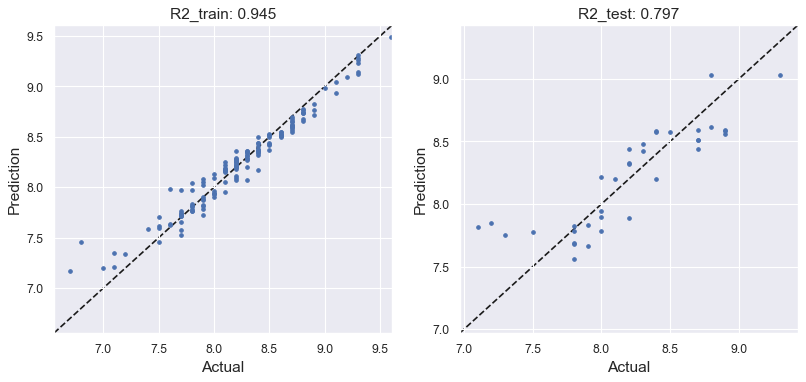

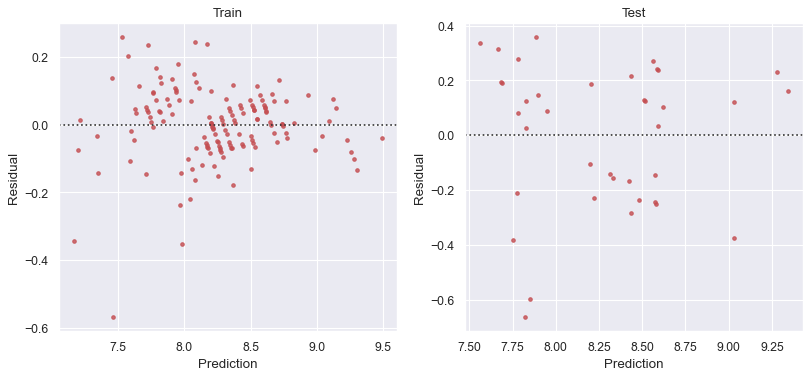

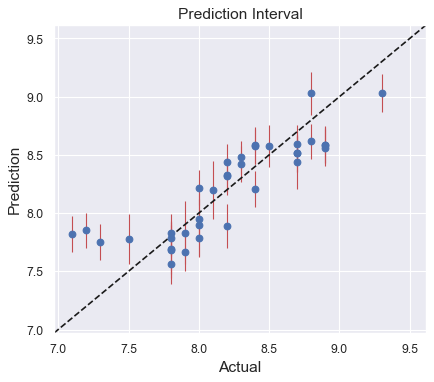

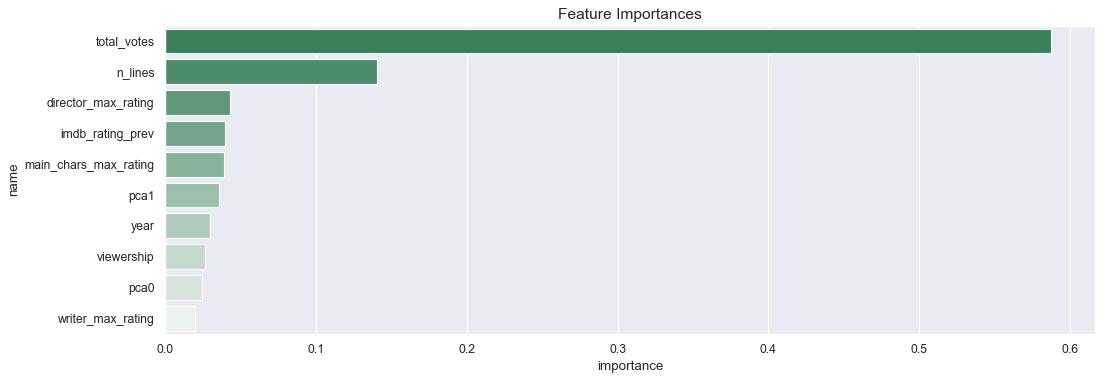

In [21]:
# Label for our dataset
label = ['imdb_rating']

# Identifier column to stratify our split
stratify = ['rating_cat']

# Columns that have low correlation and highly correlated to one of the features in cols_preserved
# e.g. n_words and n_speak_char is highly correlated to n_lines
remove_cols = ['n_words', 'n_directions', 'n_speak_char', 'writer_pop_rate', 'guest_stars_pop_rate',
               'duration', 'air_day_of_week']

# Categorical columns that are going to be encoded
cat_cols = ['writer', 'main_chars', 'director', 'guest_stars']

# Numerical columns that are going to be scaled
num_cols = [x for x in df.columns if not x in label + stratify + cat_cols + remove_cols]

# Features that are going to be preserved; perform PCA on other features
cols_preserved = ['total_votes', 'writer_max_rating', 'director_max_rating', 'main_chars_max_rating',
                  'imdb_rating_prev', 'n_lines', 'viewership', 'year', 'month']

X_train, X_test, y_train, y_test = split(df.drop(columns=remove_cols), label=label, stratify=stratify)

model = RandomForestRegressor(random_state=42, max_features=None)
pipeline = preprocess(model, num_cols, cat_cols, cols_preserved)
final_pipeline = model_fit(pipeline, X_train, X_test, y_train, y_test)
show_feature_importances(final_pipeline)

### <a id=35> 3.5 Our Model Explanation </a>

Our model, using the Random Forest Regressor, is executed above and the results from the model are shown. This section will discuss the specifics of our model and the final outcome. Pariticularly, this section will detail the metrics/scores produced, hyparameter tuning, graphical representations of the predicted vs. actual data, residuals, prediction intervals and feature importance. This section is organized as follows:
- [**3.5.1. Model Hyperparameters**](#a-id351-351-model-hyperparameters-a)
- [**3.5.2. Model Metric/Scores**](#a-id352-352-model-metricsscores-a)
- [**3.5.3. Model Graphical Representations**](#a-id353-353-model-graphical-representations-a)
- [**3.5.4. Model Feature Importance**](#a-id354-354-model-feature-importance-a)

#### <a id=351> 3.5.1 Model Hyperparameters </a>

#### <a id=352> 3.5.2 Model Metrics/Scores </a>

#### <a id=353> 3.5.3 Model Graphical Representations </a>

#### <a id=354> 3.5.4 Model Feature Importance </a>

## <a id=4> 4. Discussion and Conclusions </a>


*In this section you should provide a general overview of **your final model**, its **performance**, and **reliability**.* 

- You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant.

- This should be written with a target audience of a NBC Universal executive who is with the show and university level mathematics but not necessarily someone who has taken a postgraduate statistical modeling course. 

- Your goal should be to convince this audience that your model is both accurate and useful.

- Finally, you should include concrete recommendations on what NBC Universal should do to make their reunion episode a popular as possible.

**Keep in mind that a negative result, i.e. a model that does not work well predictively, but that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explanations / justifications.**

## 5. References

*In this section, you should present a list of external sources (except the course materials) that you used during the project, if any*

- Additional data sources can be cited here, in addition to related python documentations, any other webpage sources that you benefited from